pip install pyarrow

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scipy.signal as sig

#pip.main(['install'] + ['pyarrow'])
#import pyarrow.parquet as pq


#yearly = '/Users/athenaye/Desktop/by_year/2001.csv.gz'
ex = './Historical Data/%s.csv'
path = ex % 'LCM'
!wc -1 $psth

wc: illegal option -- 1
usage: wc [-clmw] [file ...]


## Background

In [ ]:
twenty_sixteen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2016.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_seventeen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2017.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_eighteen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2018.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_nineteen_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2019.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
twenty_twenty_sample = pd.read_csv("/Users/athenaye/Desktop/by_year/2020.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])

In [ ]:
twenty_sixteen_sample['date'] = pd.to_datetime(twenty_sixteen_sample['date'], format='%Y%m%d')
twenty_seventeen_sample['date'] = pd.to_datetime(twenty_seventeen_sample['date'], format='%Y%m%d')
twenty_eighteen_sample['date'] = pd.to_datetime(twenty_eighteen_sample['date'], format='%Y%m%d')
twenty_nineteen_sample['date'] = pd.to_datetime(twenty_nineteen_sample['date'], format='%Y%m%d')
twenty_twenty_sample['date'] = pd.to_datetime(twenty_twenty_sample['date'], format='%Y%m%d')

In [ ]:
twenty_sixteen = twenty_sixteen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_seventeen = twenty_seventeen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_eighteen = twenty_eighteen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_nineteen = twenty_nineteen_sample.pivot(index = ["date", "station"], columns = "data", values = "value")
twenty_twenty = twenty_twenty_sample.pivot(index = ["date", "station"], columns = "data", values = "value")

In [ ]:
twenty_sixteen.to_parquet("/Users/athenaye/Desktop/by_year/2016.parquet")

In [ ]:
twenty_seventeen.to_parquet("/Users/athenaye/Desktop/by_year/2017.parquet")
twenty_eighteen.to_parquet("/Users/athenaye/Desktop/by_year/2018.parquet")
twenty_nineteen.to_parquet("/Users/athenaye/Desktop/by_year/2019.parquet")
twenty_twenty.to_parquet("/Users/athenaye/Desktop/by_year/2020.parquet")

## For loop to save as a parquet

In [47]:
#Globbing
for py in glob.glob("/Users/athenaye/Desktop/by_year/*.csv"):
    csv = pd.read_csv(py, header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])
    csv['date'] = pd.to_datetime(csv['date'], format='%Y%m%d')
    pivot = csv.pivot(index = ["date", "station"], columns = "data", values = "value")
    pivot.to_parquet(py+".parquet")
    #pd.read_csv("/Users/athenaye/Desktop/by_year/2016.csv", header = None, names = ['station', 'date', 'data', 'value', 'mflag', 'qflag', 'sflag', 'time'], usecols=[0,1,2,3])

## For loop to filter columns

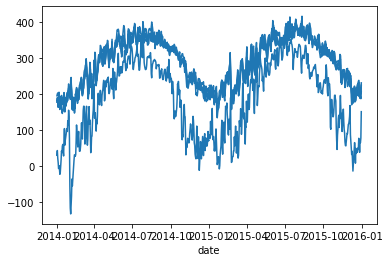

In [8]:
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
ultimatetavg = []
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):
    for s in range(len(stationlist)):
        currentparq = pd.read_parquet(f)
        currentparq = currentparq['TAVG']
        stationtavg = currentparq.xs((stationlist[s]), level = "station")
        ultimatetavg.append(stationtavg)
        sns.lineplot(data = ultimatetavg, legend = False)


In [16]:
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):
    read = pd.read_parquet(f)
    print(read.columns)

Index(['AWDR', 'AWND', 'DAPR', 'DASF', 'DATN', 'DATX', 'DWPR', 'EVAP', 'MDPR',
       'MDSF', 'MDTN', 'MDTX', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'PSUN', 'SN31',
       'SN32', 'SN33', 'SN35', 'SN36', 'SN51', 'SN52', 'SN53', 'SN55', 'SN56',
       'SNOW', 'SNWD', 'SX31', 'SX32', 'SX33', 'SX35', 'SX36', 'SX51', 'SX52',
       'SX53', 'SX55', 'SX56', 'TAVG', 'THIC', 'TMAX', 'TMIN', 'TOBS', 'TSUN',
       'WDF2', 'WDF5', 'WDFG', 'WDMV', 'WESD', 'WESF', 'WSF2', 'WSF5', 'WSFG',
       'WSFI', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08',
       'WT09', 'WT10', 'WT11'],
      dtype='object', name='data')
Index(['AWDR', 'AWND', 'DAPR', 'DASF', 'DATN', 'DATX', 'DWPR', 'EVAP', 'MDPR',
       'MDSF', 'MDTN', 'MDTX', 'MNPN', 'MXPN', 'PGTM', 'PRCP', 'PSUN', 'SN31',
       'SN32', 'SN33', 'SN35', 'SN36', 'SN51', 'SN52', 'SN53', 'SN55', 'SN56',
       'SN57', 'SNOW', 'SNWD', 'SX31', 'SX32', 'SX33', 'SX35', 'SX36', 'SX51',
       'SX52', 'SX53', 'SX55', 'SX56', 'SX57', 'TAVG', 'THIC', '

# Code

In [259]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'TAVG'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
avgoverall = ultimate.sort_values(by='date')

Done with 1 year
Done with 1 year


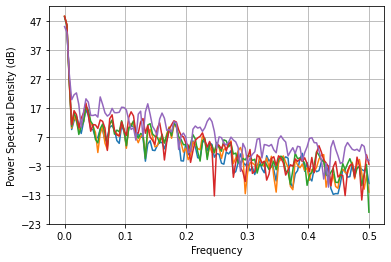

In [260]:
for x in range(len(avgoverall.columns)):
    nonan = avgoverall[avgoverall.columns[x]]
    nonan = nonan.interpolate('linear')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False)
    if x == 0:
        acumulative = a
        bcumulative = b
    else:
        acumulative = np.vstack([acumulative, a])
        bcumulative = np.vstack([bcumulative, b])
amean = acumulative.mean(axis=(0))
bmean = bcumulative.mean(axis=(0))

Done with 1 year
Done with 1 year


<AxesSubplot:xlabel='date'>

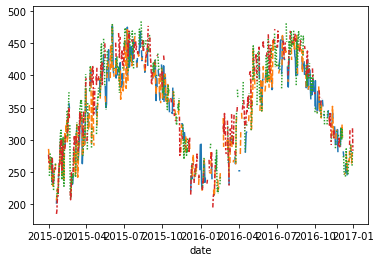

In [261]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    f = pd.DataFrame()
    parameter = 'TMAX'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
maxoverall = ultimate.sort_values(by='date')
sns.lineplot(data = maxoverall, legend = False)

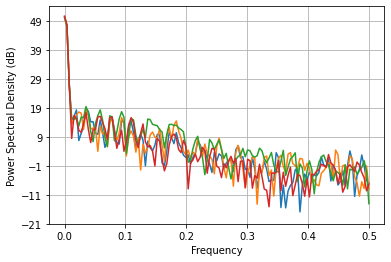

In [273]:
for x in range(len(maxoverall.columns)):
    nonan = maxoverall[maxoverall.columns[x]]
    nonan = nonan.interpolate('time', limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False)
    
    if x == 0:
        tmaxacumulative = a
        tmaxbcumulative = b
    else:
        tmaxacumulative = np.vstack([tmaxacumulative, a])
        tmaxbcumulative = np.vstack([tmaxbcumulative, b])
tmaxamean = np.nanmean(tmaxacumulative, axis=(0))
tmaxbmean = np.nanmean(tmaxbcumulative, axis=(0))

Done with 1 year
Done with 1 year


<AxesSubplot:xlabel='date'>

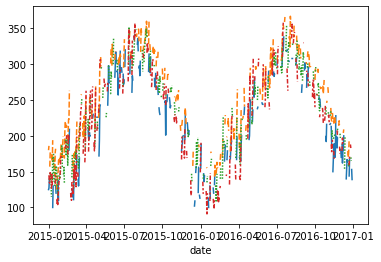

In [274]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    #print(f)
    f = pd.DataFrame()
    parameter = 'TMIN'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
minoverall = ultimate.sort_values(by='date')
sns.lineplot(data = minoverall, legend = False)


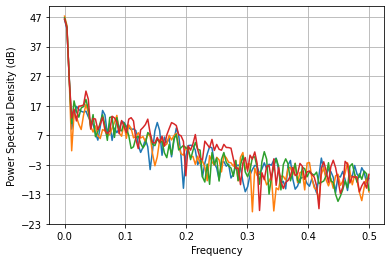

In [275]:
for x in range(len(minoverall.columns)):
    nonan = minoverall[minoverall.columns[x]]
    nonan = nonan.interpolate('time',limit_direction='both')
    a,b = plt.psd(nonan, Fs = 1, scale_by_freq = False)
    
    if x == 0:
        tminacumulative = a
        tminbcumulative = b
    else:
        tminacumulative = np.vstack([tminacumulative, a])
        tminbcumulative = np.vstack([tminbcumulative, b])
tminamean = np.nanmean(tminacumulative, axis=(0))
tminbmean = np.nanmean(tminbcumulative, axis=(0))

<AxesSubplot:>

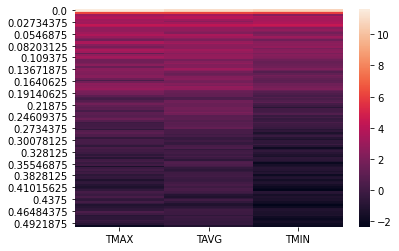

In [298]:
param1 = ['TAVG']
param2 = ['TMAX']
param3 = ['TMIN']

hm1 = pd.DataFrame(data = amean, columns = param1, index = bmean)
hm2 = pd.DataFrame(data = tmaxamean, columns = param2, index = tmaxbmean)
hm3 = pd.DataFrame(data = tminamean, columns = param3, index = tminbmean)
hm = pd.concat([hm2, hm1, hm3], axis=1)
sns.heatmap(np.log(hm))

Done with 1 year
Done with 1 year
Done with 1 year
Done with 1 year
Done with 1 year
Done with 1 year


<AxesSubplot:xlabel='date'>

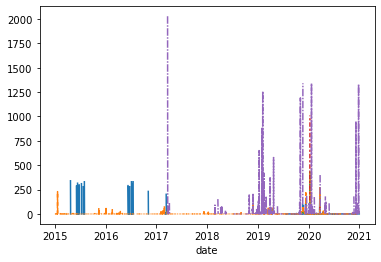

In [61]:
years = []
stationlist = ['AE000041196', 'AEM00041194', 'AEM00041217', 'AEM00041218', 'AFM00040938']
year = 0
ultimate = pd.DataFrame()
for f in glob.glob("/Users/athenaye/Desktop/by_year_parquet_trial/*.parquet"):    
    read = pd.read_parquet(f)
    #print(f)
    f = pd.DataFrame()
    parameter = 'PRCP'
    if parameter in read.columns:
        years.append(f)
    else:
        print(str(parameter)+ ' was not found in ' + f)
        break
    read = read[parameter]
    #print(read)
    for s in range(len(stationlist)):
        stationtavg = read.xs((stationlist[s]), level = "station")
        #print(stationtavg)
        f['station '+str(stationlist[s])] = stationtavg
        #print(f)
    ultimate = pd.concat([ultimate, f])
    print("Done with 1 year")
    year += 1
overall = ultimate.sort_values(by='date')
sns.lineplot(data = overall, legend = False)


<AxesSubplot:xlabel='date'>

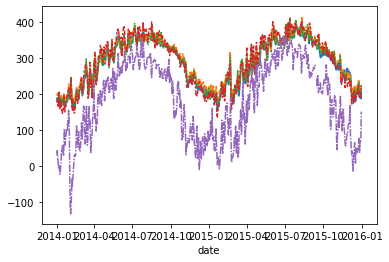

In [39]:
hi = ultimate.sort_values(by='date')
sns.lineplot(data = hi, legend = False)

## Start Here

heatmap, frequency along the x axis, row is environment variable
use fourier
across all years and all stations
concatenated time series for each station across all years, take fourier transform, do that for every station and average them togehter, important to normalize the data, separate repository for historical data project

In [ ]:
import seaborn as sns
sns.lineplot(data = wideform.iloc[: , 1:100]/10, legend=False)
plt.title("Average Temperature")
#sns.lineplot(wideform['Day Number'], wideform[:, 1:10])

In [ ]:
fftdata = np.fft.fft(wideform.iloc[: , :], axis=0)
plt.plot(np.nanmean(fftdata.real, axis=1)[1:100])
plt.plot((fftdata.real[1:]))
plt.title("Average Temperature")

#plt.plot(np.mean(wideform.iloc[: , 1:5], axis=1))

In [ ]:
twenty_nineteen_sample['date'] = pd.to_datetime(twenty_nineteen_sample['date'], format='%Y%m%d')
tmin = twenty_nineteen_sample[twenty_nineteen_sample['data']=='TMIN']
tminwideform = tmin.pivot(index = "date", columns = "station", values = "value")

In [ ]:
import seaborn as sns
sns.lineplot(data = tminwideform.iloc[: , 1:5]/10)
plt.title("Minumum Temperature")

In [ ]:
tminfftdata = np.fft.fft(tminwideform.iloc[: , :], axis=0)
plt.plot(np.nanmean(tminfftdata.real, axis=1)[1:])
plt.title("Minumum Temperature")

In [ ]:
twenty_nineteen_sample['date'] = pd.to_datetime(twenty_nineteen_sample['date'], format='%Y%m%d')
tmax = twenty_nineteen_sample[twenty_nineteen_sample['data']=='TMAX']
tmaxwideform = tmax.pivot(index = "date", columns = "station", values = "value")

In [ ]:
import seaborn as sns
sns.lineplot(data = tmaxwideform.iloc[: , 1:5]/10)
plt.title("Maximum Temperature")

In [ ]:
tmaxfftdata = np.fft.fft(tminwideform.iloc[: , :], axis=0)
#plt.plot(np.nanmean(tminfftdata.real, axis=1)[1:])
plt.plot(np.nanmean(tmaxfftdata.real, axis=1)[1:])
plt.plot((tmaxfftdata.real[1:]))
plt.title("Maximum Temperature")
#plt.plot(np.nanmean(fftdata.real, axis=1)[1:])

# DAILY SUMMARIES

## Precipitation

In [25]:
#Pivot for Precipitation
prcpunpivoted = twenty_nineteen_sample[twenty_nineteen_sample['data']=="PRCP"]
prcp=prcpunpivoted.pivot(index='date', columns="station", values = "value")
prcp

NameError: name 'twenty_nineteen_sample' is not defined

In [ ]:
#Precipitation Plot
import seaborn as sns
sns.lineplot(data = prcp.iloc[: , 1:100], legend=False)
plt.title("Precipitation Plot")

In [ ]:
#Precipitation Fourier
prcpftt = np.fft.fft(prcp.iloc[: , 1:100], axis=0)
plt.plot((prcpftt.real)[1:])
plt.title("Precipitation Fourier Transform")

#plt.plot(np.mean(wideform.iloc[: , 1:5], axis=1))

## Snow

In [ ]:
#Snow Plot
snowunpivoted=twenty_nineteen_sample[twenty_nineteen_sample['data']=="SNOW"]
snow=snowunpivoted.pivot(index='date', columns="station", values = "value")
sns.lineplot(data = snow.iloc[: , 1:100], legend = False)
plt.title("Snow Plot")

In [ ]:
#Snow Fourier
snowlcd = np.fft.fft(lcd.iloc[: , 6], axis=0)
snoweastcoast = np.fft.fft(eastcoastsnow.iloc[: , :], axis=0)
plt.plot((snowlcd.real)[1:])
plt.plot((snoweastcoast.real)[1:])
plt.title("Snow Fourier Transform")

## Average Temp

In [ ]:
tavgunpivoted=twenty_nineteen_sample[twenty_nineteen_sample['data']=="TAVG"]
tavg=tavgunpivoted.pivot(index='date', columns="station", values = "value")
sns.lineplot(data = tavg.iloc[: , 1:100]/10, legend = False)
#sns.lineplot(data = eastcoasttavg.iloc[: , :], legend = False)
plt.title("Average Temp Plot")
#average of all average temperatures each year
# then do for every year
#take average of each site for all time points (last 10 years)

In [ ]:
tavgfourier = np.fft.fft(tavg.iloc[: , 1:100], axis=0)
plt.plot(abs((tavgfourier.real)[1:]))
plt.title("Average Temp Transform")
# make on 10 year long dataa set and take the fourier transform of that, for each station, and then average for all of the stations
# label the fourier
# take absolute value
# fourier power spectrum


## Fastest 2-minute Wind Speed 

In [ ]:
#Avg Wind Speed Plot
eastcoastwsf2=eastcoast2019.pivot(index='DATE', columns="STATION", values = "WSF2")
sns.lineplot(data = lcd.iloc[: , 13])
sns.lineplot(data = eastcoastwsf2.iloc[: , :], legend = False)
plt.title("Fastest 2-minute Wind Speed Plot")

In [ ]:
#Avg Wind Speed Fourier
wsf2lcd = np.fft.fft(lcd.iloc[: , 13], axis=0)
wsf2eastcoast = np.fft.fft(eastcoastwsf2.iloc[: , :], axis=0)
plt.plot((wsf2lcd.real)[1:])
plt.plot((wsf2eastcoast.real)[1:])
plt.title("Fastest 2-minute Wind Speed  Fourier Transform")

## Average Wind Speed

In [ ]:
#Avg Wind Speed Plot
eastcoastawnd=eastcoast2019.pivot(index='DATE', columns="STATION", values = "AWND")
sns.lineplot(data = lcd.iloc[: , 4])
sns.lineplot(data = eastcoastawnd.iloc[: , :], legend = False)
plt.title("Average Wind Speed Plot")

In [ ]:
#Snow Fourier
awndlcd = np.fft.fft(lcd.iloc[: , 4], axis=0)
awndeastcoast = np.fft.fft(eastcoastsnow.iloc[: , :], axis=0)
plt.plot((awndlcd.real)[1:])
plt.plot((awndeastcoast.real)[1:])
plt.title("Snow Fourier Transform")

# Extra

In [ ]:
import seaborn as sns
sns.lineplot(data = lcd.iloc[: , 7])
plt.title("Average Temp Plot")

In [ ]:
prcpftt = np.fft.fft(lcd.iloc[: , 7], axis=0)
plt.plot((prcpftt.real)[1:])
plt.title("Average Temp Fourier")